In [7]:
import init_paths
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def load_coef_var(train_types):
    var_dic = {'eval_subj': [],
            'coef_var': [],
            'logalpha': [],
            'eval_dataset': [],
            'coef_norm': []}
    for dataset_name, (train_ses, eval_ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=eval_ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id

        dirname=[]
        mname=[]
        for a in la:
            dirname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg")
            mname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg_A{a}")

        fm,_ = rm.get_fitted_models(dirname,mname,config)
        for a, alpha in enumerate(la):
            for conn_model in fm[a]:
                var_dic['coef_var'].append(np.nanmean(conn_model.coef_var))
                var_dic['coef_norm'].append(np.linalg.norm(np.nan_to_num(conn_model.coef_), ord='fro'))
            var_dic['eval_subj'].extend(config["subj_list"])
            var_dic['logalpha'].extend([alpha]*(len(var_dic['coef_var'])-len(var_dic['logalpha'])))
        var_dic['eval_dataset'].extend([dataset_name]*(len(var_dic['coef_var'])-len(var_dic['eval_dataset'])))

    var_df = pd.DataFrame(var_dic)
    var_df['subj_id'] = var_df['eval_subj']
    var_df['train_dataset'] = var_df['eval_dataset']
    var_df['effective_weight'] = var_df['coef_norm'] / var_df['coef_var']
    return var_df

## Within and Between Datasets

In [9]:
dataset_list = ["MDTB", "WMFS", "Nishimoto"]
eval_data = ["MDTBs2", "WMFS02", "Nishimoto02"]
models = []
for dataset_name in dataset_list:
    models.append(dataset_name+"-ind")
    models.append(dataset_name+"-loo")

df = rm.comb_eval(models=models,methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
df.loc[df.model.isna() & (df.train_dataset==df.eval_dataset) & (df.subj_id == df.eval_subj), 'model'] = 'same'
df.loc[df.model.isna() & (df.train_dataset==df.eval_dataset) & (df.subj_id != df.eval_subj), 'model'] = 'diff'
df.loc[df.model.isna() & (df.train_dataset!=df.eval_dataset), 'model'] = 'diff'

#### $\log(\alpha)$ Comparison

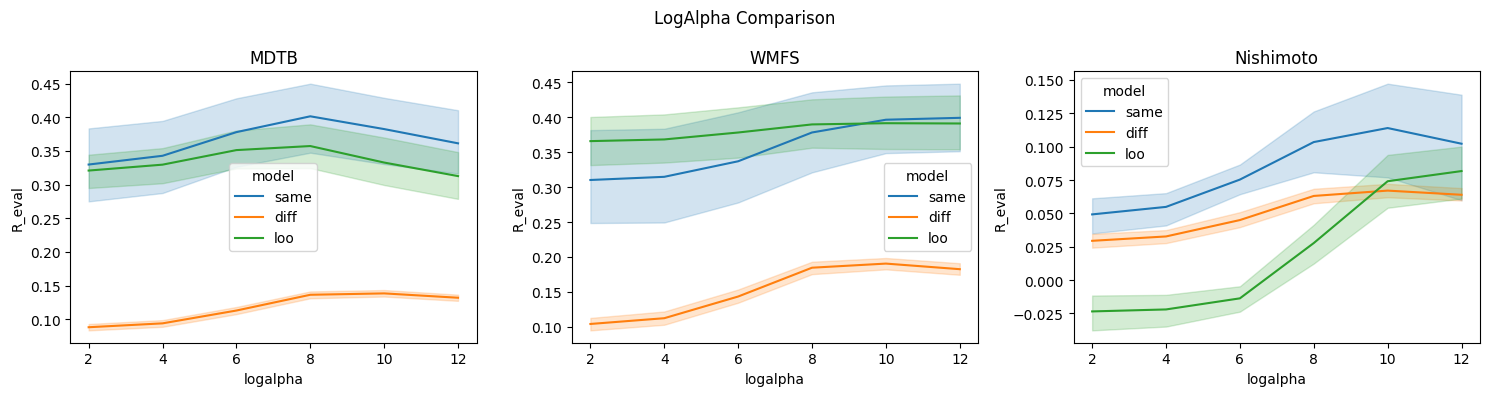

In [10]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df[df['eval_dataset'] == dataset]
    means = df_to_eval.groupby('model')['R_eval'].mean().sort_values(ascending=True)
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10", hue_order=["same", "diff", "loo"])
    plt.title(dataset)
plt.tight_layout()

#### Performance Matrix Analysis

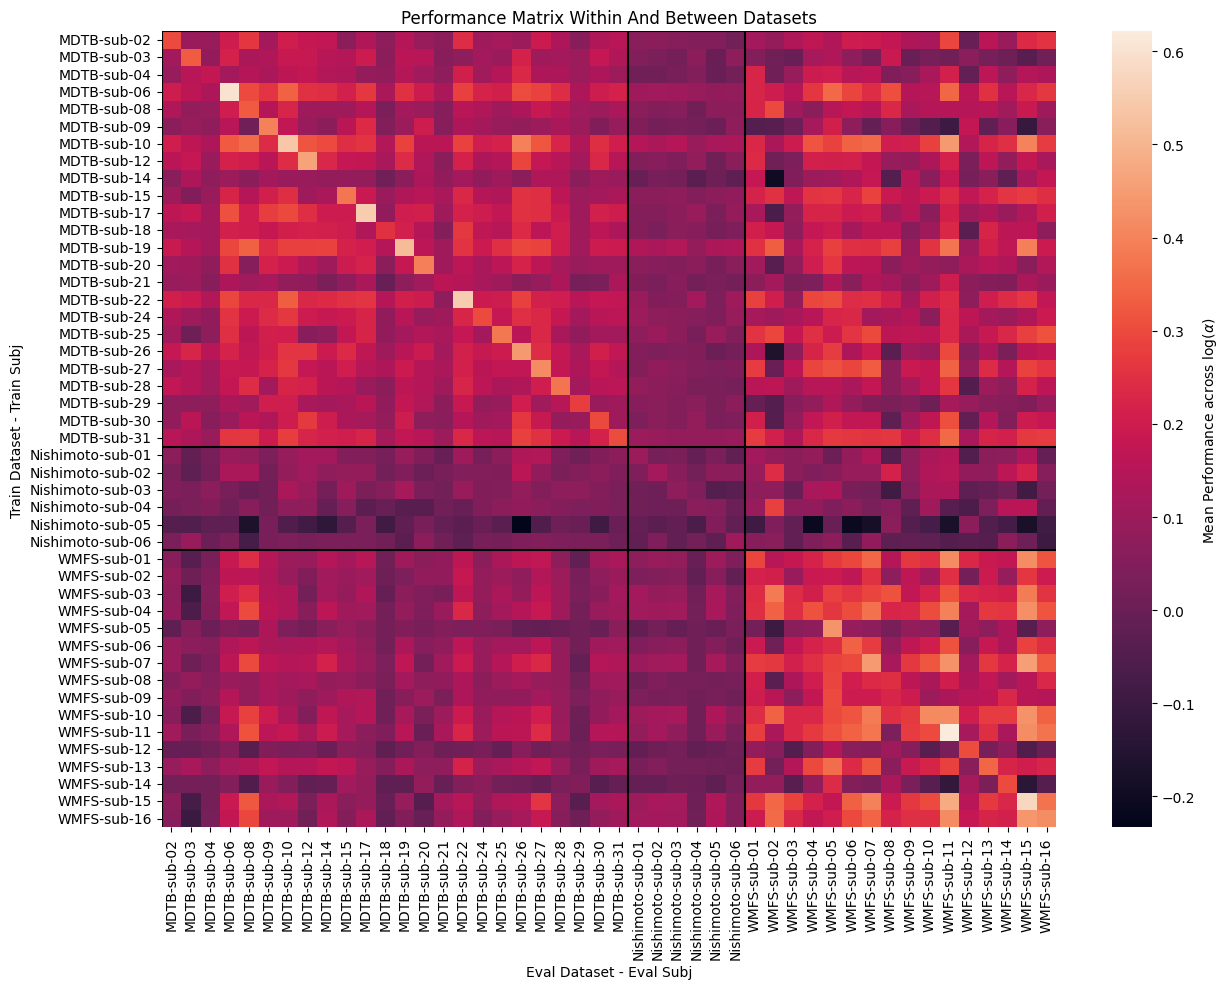

In [11]:
logalpha_list = [2, 4, 6, 8, 10, 12]
df_to_show = df[df.logalpha.isin(logalpha_list) & ((df.model=='same')|(df.model=='diff'))]
pivot_df = df_to_show.pivot_table(index=['train_dataset', 'subj_id'], columns=['eval_dataset', 'eval_subj'], values='R_eval', aggfunc='mean')

plt.figure(figsize=(13,10))
sns.heatmap(pivot_df, cbar_kws={'label': r'Mean Performance across $\log(\alpha)$'})

eval_positions = [pivot_df.columns.get_loc((eval_dataset, df_to_show[df_to_show['eval_dataset'] == eval_dataset]['eval_subj'].unique()[0])) for eval_dataset in dataset_list]
train_positions = [pivot_df.index.get_loc((train_dataset, df_to_show[df_to_show['train_dataset'] == train_dataset]['subj_id'].unique()[0])) for train_dataset in dataset_list]
for posv, posh in zip(eval_positions, train_positions):
    plt.axvline(x=posv, linewidth=1.5, color='black')
    plt.axhline(y=posh, linewidth=1.5, color='black')

plt.xlabel('Eval Dataset - Eval Subj')
plt.ylabel('Train Dataset - Train Subj')
plt.title('Performance Matrix Within And Between Datasets')
plt.tight_layout()

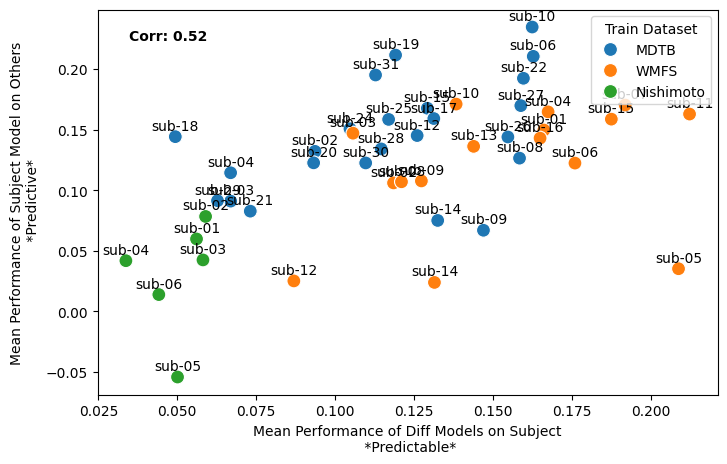

In [12]:
diff_df = df[df.model=='diff'].copy()
mean_performance_train = diff_df.groupby(['train_dataset', 'subj_id'])['R_eval'].mean().reset_index()
mean_performance_eval = diff_df.groupby(['eval_dataset', 'eval_subj'])['R_eval'].mean().reset_index()
mean_performance = pd.merge(mean_performance_train, mean_performance_eval,
                            left_on=['train_dataset', 'subj_id'], right_on=['eval_dataset', 'eval_subj'], suffixes=('_subj_id', '_eval_subj'))

plt.figure(figsize=(8,5))
sns.scatterplot(data=mean_performance, x='R_eval_eval_subj', y='R_eval_subj_id', hue='train_dataset', palette='tab10', s=100, hue_order=dataset_list)

# Write Correlation
corr, _ = stats.pearsonr(mean_performance['R_eval_eval_subj'], mean_performance['R_eval_subj_id'])
plt.annotate(f'Corr: {corr:.2f}', xy=(.05, .95), xycoords='axes fraction', ha='left', va='top', fontsize=10, fontweight='bold')

# Write subj names
for d, dataset_name in enumerate(dataset_list):
    subset_mean_performance = mean_performance[mean_performance['train_dataset']==dataset_name]
    for i, sub in enumerate(subset_mean_performance['subj_id']):
        plt.annotate(f'{sub}', (subset_mean_performance['R_eval_eval_subj'].iloc[i], subset_mean_performance['R_eval_subj_id'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Mean Performance of Diff Models on Subject\n *Predictable*')
plt.ylabel('Mean Performance of Subject Model on Others\n *Predictive*')
plt.legend(title='Train Dataset')

In [13]:
logalpha_list = [2, 4, 6, 8, 10, 12]
train_types = {
    'MDTB':        ('ses-s1',     'ses-s2',      logalpha_list),
    'WMFS':        ('ses-01',     'ses-02',      logalpha_list),
    'Nishimoto':   ('ses-01',     'ses-02',      logalpha_list),
}

In [14]:
# If you don't have access to var_df.tsv you should run this to save it:
# var_df = load_coef_var(train_types)
# var_df.to_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/var_df.tsv', sep='\t', index=False)

# If you have var_df.tsv you can just load it
var_df = pd.read_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/var_df.tsv', sep='\t')

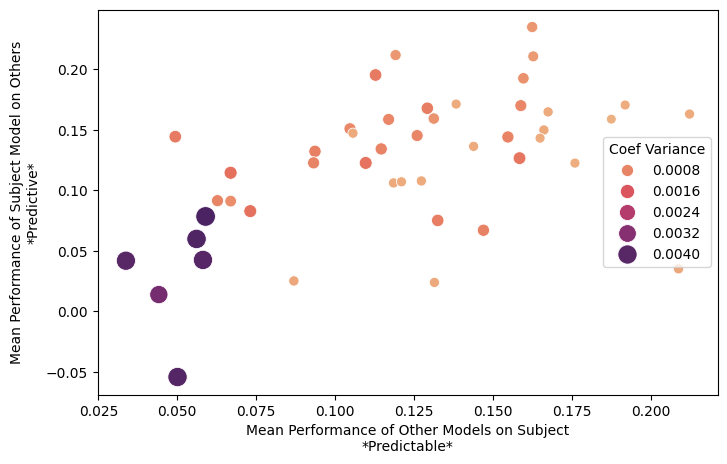

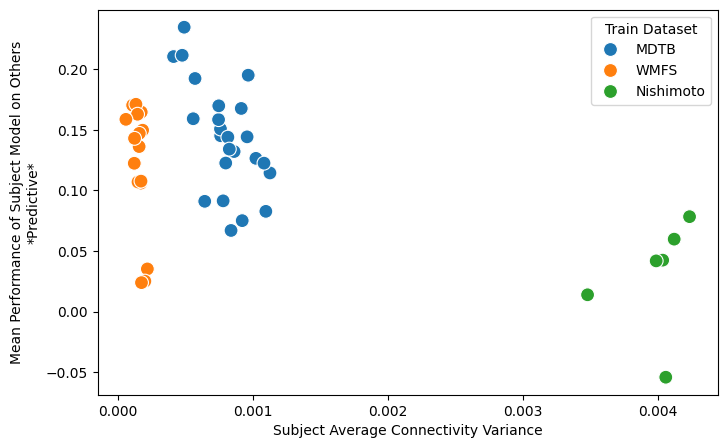

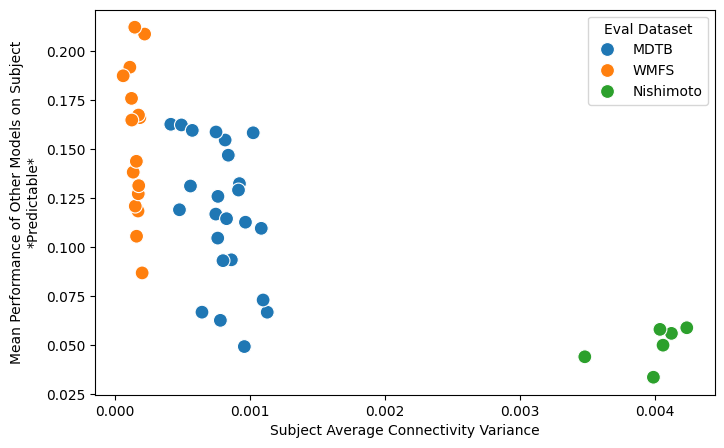

In [15]:
diff_df = df[df.model=='diff'].copy()
mean_performance_train = pd.merge(diff_df, var_df, on=['train_dataset', 'subj_id', 'logalpha'], how='left')
mean_performance_train = mean_performance_train.groupby(['train_dataset', 'subj_id']).agg({'coef_var': 'mean', 'R_eval': 'mean'}).reset_index()
mean_performance_eval = pd.merge(diff_df, var_df, on=['eval_dataset', 'eval_subj', 'logalpha'], how='left')
mean_performance_eval = mean_performance_eval.groupby(['eval_dataset', 'eval_subj']).agg({'coef_var': 'mean', 'R_eval': 'mean'}).reset_index()
mean_performance = pd.merge(mean_performance_train, mean_performance_eval,
                            left_on=['train_dataset', 'subj_id'], right_on=['eval_dataset', 'eval_subj'], suffixes=('_subj_id', '_eval_subj'))

plt.figure(figsize=(8,5))
sns.scatterplot(data=mean_performance, x='R_eval_eval_subj', y='R_eval_subj_id', hue='coef_var_subj_id',
                palette=sns.color_palette('flare', as_cmap=True), size='coef_var_subj_id', sizes=(50,200))
plt.xlabel('Mean Performance of Other Models on Subject\n*Predictable*')
plt.ylabel('Mean Performance of Subject Model on Others\n*Predictive*')
plt.legend(title='Coef Variance')
corr, _ = stats.pearsonr(mean_performance['R_eval_eval_subj'], mean_performance['R_eval_subj_id'])

plt.figure(figsize=(8,5))
sns.scatterplot(data=mean_performance_train, x='coef_var', y='R_eval', hue='train_dataset', palette='tab10', s=100, hue_order=dataset_list)
plt.xlabel('Subject Average Connectivity Variance')
plt.ylabel('Mean Performance of Subject Model on Others\n*Predictive*')
plt.legend(title='Train Dataset')
corr, _ = stats.pearsonr(mean_performance_train['coef_var'], mean_performance_train['R_eval'])

# write subject names
# plt.annotate(f'Corr: {corr:.2f}', xy=(.95, .95), xycoords='axes fraction', ha='right', va='top', fontsize=10, fontweight='bold')
# for i, sub in enumerate(mean_performance_train['subj_id']):
#     plt.annotate(f'{sub}', (mean_performance_train['coef_var'].iloc[i], mean_performance_train['R_eval'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.figure(figsize=(8,5))
sns.scatterplot(data=mean_performance_eval, x='coef_var', y='R_eval', hue='eval_dataset', palette='tab10', s=100, hue_order=dataset_list)
plt.xlabel('Subject Average Connectivity Variance')
plt.ylabel('Mean Performance of Other Models on Subject\n*Predictable*')
plt.legend(title='Eval Dataset')
corr, _ = stats.pearsonr(mean_performance_eval['coef_var'], mean_performance_eval['R_eval'])

# write subject names
# plt.annotate(f'Corr: {corr:.2f}', xy=(.95, .95), xycoords='axes fraction', ha='right', va='top', fontsize=10, fontweight='bold')
# for i, sub in enumerate(mean_performance_eval['eval_subj']):
#     plt.annotate(f'{sub}', (mean_performance_eval['coef_var'].iloc[i], mean_performance_eval['R_eval'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')